In [33]:
import psycopg2
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
import datetime as dt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
plt.rcParams['font.family'] = 'Ubuntu'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['figure.figsize'] = [10,6]

class NlpProcessor(object):

    def __init__(self, log_file_path, log_lda, palette):
        self.conn = self.open_conn()
        self.log_file_path = log_file_path
        self.log_lda = log_lda
        self.palette = palette

    def open_conn(self):
        return psycopg2.connect(dbname='therapist_predictor', user='postgres', host='localhost', password='password')

    def close_conn(self):
        self.conn = None

    def sql_to_pandas(self, sql:str)->pd.DataFrame:
        df = pd.read_sql_query(sql, self.conn)

        return df

    # tokenizing with nltk, with stemming/lemmatizing
    # this keeps punctuation
    def tokenize_doc(self, set_of_docs)->list:
        return [word_tokenize(content.lower()) for content in set_of_docs ]

    def remove_stopwords_and_punc(self, tokenized_set_of_docs:list, stop_words, remove_punc=True)->list:
        no_stops_docs = []
        for tokens in tokenized_set_of_docs:
            saved_tokens = []
            for token in tokens:
                if remove_punc:
                    if token.isalpha():
                        if token not in stop_words:
                            saved_tokens.append(token)
                else:
                    if token not in stop_words:
                        saved_tokens.append(token)
            no_stops_docs.append(saved_tokens)
            #no_stops_docs.append([word for word in words if word not in final_stop_words and word])
        
        return no_stops_docs

    def stem_porter(self, tokenized_set_of_docs:list)->list:
        porter = PorterStemmer()
        porter_docs = []
        for words in tokenized_set_of_docs:
            porter_docs.append([porter.stem(word) for word in words])
        
        return porter_docs

    def stem_snowball(self, tokenized_set_of_docs:list)->list:
        snowball = SnowballStemmer('english')
        snowball_docs = []
        for words in tokenized_set_of_docs:
            snowball_docs.append([snowball.stem(word) for word in words])
        
        return snowball_docs

    def lemm_wordnet(self, tokenized_set_of_docs:list)->list:
        wordnet = WordNetLemmatizer()
        wordnet_docs = []
        for words in tokenized_set_of_docs:
            wordnet_docs.append([wordnet.lemmatize(word) for word in words])
        
        return wordnet_docs

    def text_tokenization_pipeline(self, list_of_docs : list, stop_words, remove_punc : bool, tokenizer='wordnet') -> list:
        tokenized_docs = self.tokenize_doc(list_of_docs)
        no_stops_docs = self.remove_stopwords_and_punc(tokenized_docs, stop_words, remove_punc=remove_punc)
        lemm_stemm_docs = []
        if tokenizer == 'wordnet':
            lemm_stemm_docs = self.lemm_wordnet(no_stops_docs)
        elif tokenizer == 'porter':
            lemm_stemm_docs = self.stem_porter(no_stops_docs)
        elif tokenizer == 'snowball':
            lemm_stemm_docs = self.stem_snowball(no_stops_docs)
        else:
            lemm_stemm_docs = no_stops_docs
            
        return lemm_stemm_docs

    def remove_dupes_decorator(self, func):
        def func_wrapper(*args, **kwargs):
            dupes_removed_docs = func(*args, **kwargs)
            
            return [list(set(ls)) for ls in dupes_removed_docs]

        return func_wrapper

    def combine_stop_words(self, custom_stop_words:list)->list:
        stop_words = set(stopwords.words('english'))

        return stop_words.union(custom_stop_words)

    def create_tf_matrix(self, docs, all_stop_words:list, n_gram_range, max_features, remove_punc=True, tokenizer='None'):
        tokens = self.text_tokenization_pipeline(docs,stop_words=all_stop_words,
                                                remove_punc=True, tokenizer=tokenizer)

        documents = [' '.join(doc) for doc in tokens]

        count_vect = CountVectorizer(max_features=max_features, ngram_range=n_gram_range)
        tf_matrix = count_vect.fit_transform(documents)

        return tf_matrix, count_vect

    def create_tf_idf_matrix(self, docs, all_stop_words:list,max_feats , n_gram_range, tokenizer='None'):
        # tokens is a list of lists - words per document
        tokens = nlp.text_tokenization_pipeline(docs, stop_words=all_stop_words,
                                                    remove_punc=True, tokenizer=tokenizer)

        # reconstruct each document after processing
        documents = [' '.join(doc) for doc in tokens]
        tfidf_vect = TfidfVectorizer(ngram_range=n_gram_range,max_features=max_feats, lowercase=False)
        tfidf_matrix = tfidf_vect.fit_transform(documents)
        #print(tfidf_vect.get_feature_names())
        
        return tfidf_matrix

    def get_most_freq_words(self, count_vectorizer, tf_matrix, num_words, print_dict_to_terminal=False):
        top_words = []
        word_freqs = []
        
        word_list = count_vect.get_feature_names()
        count_list = tf_matrix.toarray().sum(axis=0)

        #combine these in a dictionary
        word_freq_dict = dict(zip(word_list, count_list))
        
        # dictionary.values() and .keys() return a view object, so we have to cast it to list in order to use it as desired
        print('Most Frequent n grams')
        for word_index in np.argsort(list(word_freq_dict.values()))[-num_words:]:
            top_words.append(list(word_freq_dict.keys())[word_index])
            word_freqs.append(list(word_freq_dict.values())[word_index])
            if print_dict_to_terminal:
                print(f'{list(word_freq_dict.keys())[word_index]} : {list(word_freq_dict.values())[word_index]}')
            
        return top_words, word_freqs
        
    def display_topics(self, model, feature_names, num_top_n_grams, custom_stopwords)->None:
        topic_ngram_dict = {}

        for topic_idx, topic in enumerate(model.components_):
            topic_header = "Topic %d:" % (topic_idx)
            print(topic_header)
            single_topic_n_grams = []
            for i in topic.argsort()[:-num_top_n_grams - 1:-1]:
                single_topic_n_grams.append(feature_names[i]) 

            print(single_topic_n_grams)
            topic_ngram_dict[topic_idx] = single_topic_n_grams
        if self.log_lda:
            self.log_lda_results(model.get_params(), topic_ngram_dict, custom_stopwords)

    def log_lda_results(self, model_params:dict, topic_ngram_dict:dict, custom_stopwords:list)->None:
        file_log = open(self.log_file_path, 'a')

        header = '\n\n**************************************** LDA Results ****************************************'
        date_and_time = 'Timestamp: ' + str(dt.datetime.now())
        model_params_header = '\nModel Parameters: \n-------------------------'
        params_str = ''
        for k, v in model_params.items():
            params_str += f'{k} : {v}\n'

        stopwords_header = 'Stop words used:'
        stopwords_str = ', '.join([stop for stop in custom_stopwords])
        stopwords_str += '\n'

        L = [header, date_and_time, model_params_header, params_str, stopwords_header, stopwords_str]

        for topic_idx, n_gram_list in topic_ngram_dict.items():
            L.append(f'Topic: {str(topic_idx)}\n\t{", ".join([ng for ng in n_gram_list])}')
        # topics = ''
        # for i, words in enumerate(topic_words_list):
        #     topics += f'Topic {i+1}\n\t{words}'

        for i in range(len(L)):
            L[i] += '\n'
        file_log.writelines(L)
        file_log.close()

    def plot_2_pca_comps(self, X_pca:np.ndarray, title_suffix='', filename_suffix='')->None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.scatter(X_pca[:, 0], X_pca[:, 1],
                cmap=plt.cm.Set1, edgecolor='k', s=40)
        ax.set_title(f'First two PCA directions {title_suffix}')
        ax.set_xlabel("1st eigenvector (PC1)")
        ax.set_ylabel("2nd eigenvector (PC2)")
        plt.tight_layout()
        plt.savefig(f'../img/data_vis/pca_2_comps_{filename_suffix}.png')
        #plt.show()

    def scree_plot(self, pca:np.ndarray, title='', filename_suffix='')->None:
        # plot explained variance ratio in a scree plot
        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.axes([.2, .2, .7, .7])
        plt.plot(pca.explained_variance_, linewidth=2, color=self.palette[0])
        plt.axis('tight')
        plt.xlabel('n_components')
        plt.ylabel('explained_variance_')
        plt.title(title)
        plt.tight_layout()
        plt.savefig(f'../img/data_vis/pca_scree_{filename_suffix}.png')
        #plt.show()
    
    def cum_scree_plot(self, pca:np.ndarray, title='', filename_suffix='')->None:
        total_variance = np.sum(pca.explained_variance_)
        cum_variance = np.cumsum(pca.explained_variance_)
        prop_var_expl = cum_variance/total_variance

        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(prop_var_expl, color=self.palette[0], linewidth=2, label='Explained variance')
        ax.axhline(0.9, label='90% goal', linestyle='--', color=self.palette[3], linewidth=1)
        ax.set_ylabel('cumulative prop. of explained variance')
        ax.set_xlabel('number of principal components')
        plt.title(title)
        ax.legend()
        plt.tight_layout()
        plt.savefig(f'../img/data_vis/pca_cum_scree_{filename_suffix}.png')
        #plt.show()

    def save_initial_eda_charts(self, df):
        # word length histogram
        writing_lengths = []
        for body in df['writing_sample']:
            writing_lengths.append(len(body))
            
        writing_lengths.sort()

        mean = np.mean(writing_lengths)
        mean_label = f'Mean: {np.around(mean, decimals=0)}'
        c1 = self.palette[0]
        c2 = self.palette[4]
        fig, ax = plt.subplots()
        ax.set_xlabel('Word Count')
        ax.set_ylabel('Therapists')
        ax.set_title('Practice Description Word Counts')
        ax.hist(writing_lengths, bins=100, color=c1)
        ax.axvline(x=mean, c=c2)
        plt.text(mean+200, 22, mean_label, bbox=dict(facecolor=c2, alpha=0.5))
        plt.savefig('../img/data_vis/word_count_hist.png')

        # number of unique values per category
        age_groups_unique_size = df_age_groups['age_group'].unique().size
        issues_unique_size = df_issues['issue'].unique().size
        orientations_unique_size = df_orientations['orientation'].unique().size
        professions_unique_size = df_professions['profession'].unique().size
        service_unique_size = df_services['service'].unique().size

        heights = [age_groups_unique_size, issues_unique_size, orientations_unique_size,
           professions_unique_size, service_unique_size]
        labels = ['age groups', 'issues', 'orientations', 'professions', 'services']
        colors = [self.palette[i] for i in range(len(heights))]

        fig, ax = plt.subplots()
        ax.set_title('Unique Entries for Profile Categories')
        ax.set_ylabel('Number of Unique Entries')
        ax.bar(height = heights, x=labels, color=colors)
        plt.savefig('../img/data_vis/uniques_per_category.png')

        # has website bar chart
        mask_no_website = df['website']=='None'
        height = [df[~mask_no_website]['website'].size, df[mask_no_website]['website'].size]
        labels = ['Website', 'No Website']

        c = [self.palette[0], self.palette[3]]
        fig, ax = plt.subplots()
        ax.bar(labels, height, color=c)
        ax.set_title("Therapists with Websites")
        plt.savefig('../img/data_vis/website_bar.png')

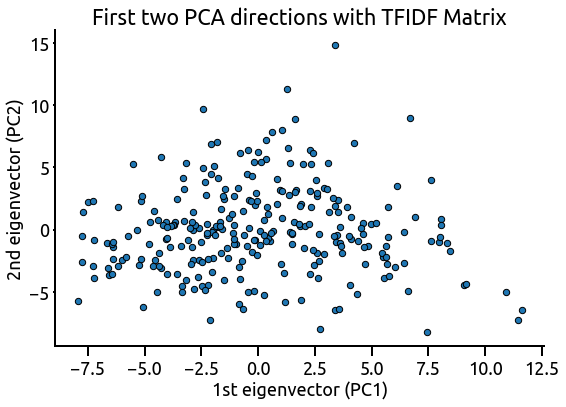

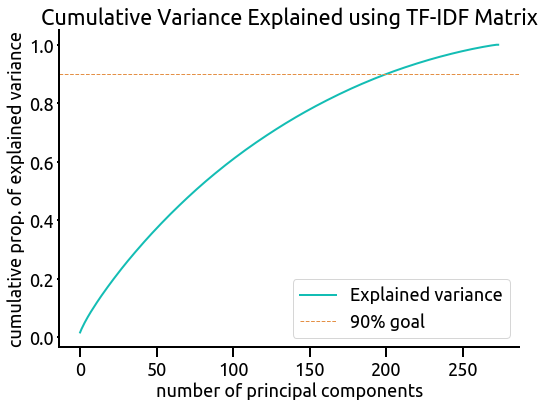

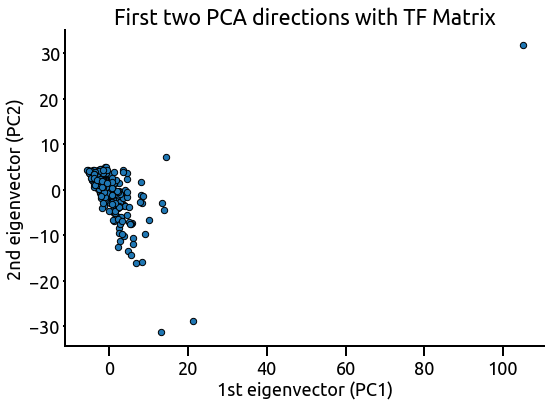

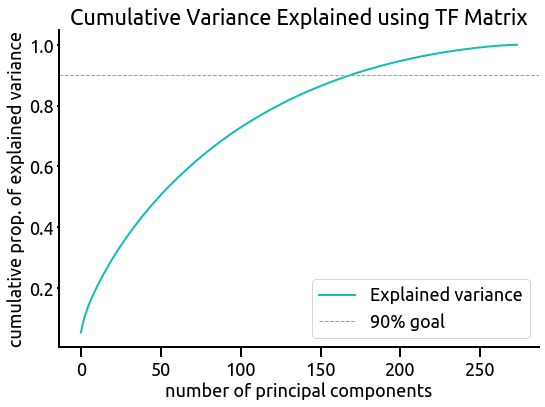

In [34]:
palette = ['#13bdb4','#80d090','#dad977','#e49046','#d43d51']
nlp = NlpProcessor(log_file_path='../logs/lda_results_log.txt', log_lda=False, palette=palette)

sql = "select * from therapists;"
df = nlp.sql_to_pandas(sql)

sql_age = 'SELECT * FROM age_groups;'
sql_issues = 'SELECT  * FROM issues;'
sql_orientations = 'SELECT * FROM orientations'
sql_professions = 'SELECT * FROM professions'
sql_services = 'SELECT * FROM services'

df_age_groups = nlp.sql_to_pandas(sql_age)
df_issues = nlp.sql_to_pandas(sql_issues)
df_orientations = nlp.sql_to_pandas(sql_orientations)
df_professions = nlp.sql_to_pandas(sql_professions)
df_services = nlp.sql_to_pandas(sql_services)

nlp.close_conn()
#nlp.save_initial_eda_charts(df)

custom_stopwords = ['change','family','find','approach','couples','issues','also',
'anxiety','working','experience','relationship','relationships','therapist','counseling',
'people','feel','clients','help','work','life','therapy','psychotherapy', 'feel', 
'feeling','get', 'warson', 'counseling', 'way', 'practice', 'call', 'today']
#custom_stop_words = []

final_stop_words = nlp.combine_stop_words(custom_stopwords)

tfidf_matrix = nlp.create_tf_idf_matrix(df['writing_sample'], all_stop_words=final_stop_words,max_feats=1000, n_gram_range=(1,3), tokenizer='None')

tf_matrix, count_vect = nlp.create_tf_matrix(docs=df['writing_sample'], all_stop_words=final_stop_words, n_gram_range=(1,3), 
    max_features=1000, remove_punc=True, tokenizer='wordnet')

# PCA with TFIDF
X_tfidf_scaled = scaler.fit_transform(tfidf_matrix.todense()) # standardize data

# Just 2 components - see any sig change between component 1 and 2? Hopefully!
pca_tfidf = PCA(n_components=2) 
X_pca_tfidf = pca_tfidf.fit_transform(X_tfidf_scaled) 
nlp.plot_2_pca_comps(X_pca_tfidf, title_suffix='with TFIDF Matrix', filename_suffix='tfidf')

# How many components will explain enough variance?
pca_tfidf = PCA()
pca_tfidf.fit(X_tfidf_scaled)
nlp.cum_scree_plot(pca_tfidf, title='Cumulative Variance Explained using TF-IDF Matrix', filename_suffix='tfidf')


# PCA with TF
X_tf_scaled = scaler.fit_transform(tf_matrix.todense()) # standardize data

# with just 2
pca_tf = PCA(n_components=2)
X_pca_tf = pca_tf.fit_transform(X_tf_scaled)
nlp.plot_2_pca_comps(X_pca_tf, title_suffix='with TF Matrix', filename_suffix='tf')

# How many components will explain enough variance?
pca_tf = PCA()
pca_tf.fit(X_tf_scaled)
nlp.cum_scree_plot(pca_tf, title='Cumulative Variance Explained using TF Matrix', filename_suffix='tf')


# LDA
# num_topics = 5
# lda = LatentDirichletAllocation(n_components=num_topics, learning_offset = 50., verbose=1,
#                                 doc_topic_prior=1/num_topics, topic_word_prior= 1/num_topics,
#                                 n_jobs=-1, learning_method = 'online',
#                                 random_state=0)

# lda.fit(tf_matrix)

# num_top_n_grams = 10
# tf_feature_names = count_vect.get_feature_names()
# print(nlp.display_topics(lda, tf_feature_names, num_top_n_grams, custom_stopwords))
# print("\nModel perplexity: {0:0.3f}".format(lda.perplexity(tf_matrix)))

# words, counts = nlp.get_most_freq_words(count_vect, tf_matrix, 20, print_dict_to_terminal=True)

In [20]:
# MAIN
'''
palette = ['#13bdb4','#80d090','#dad977','#e49046','#d43d51']
nlp = NlpProcessor(log_file_path='../logs/lda_results_log.txt', log_lda=False, palette=palette)

sql = "select * from therapists;"
df = nlp.sql_to_pandas(sql)

sql_age = 'SELECT * FROM age_groups;'
sql_issues = 'SELECT  * FROM issues;'
sql_orientations = 'SELECT * FROM orientations'
sql_professions = 'SELECT * FROM professions'
sql_services = 'SELECT * FROM services'

df_age_groups = nlp.sql_to_pandas(sql_age)
df_issues = nlp.sql_to_pandas(sql_issues)
df_orientations = nlp.sql_to_pandas(sql_orientations)
df_professions = nlp.sql_to_pandas(sql_professions)
df_services = nlp.sql_to_pandas(sql_services)

nlp.close_conn()

custom_stopwords = ['change','family','find','approach','couples','issues','also',
'anxiety','working','experience','relationship','relationships','therapist','counseling',
'people','feel','clients','help','work','life','therapy','psychotherapy', 'feel', 
'feeling','get', 'warson', 'counseling', 'way', 'practice', 'call', 'today']
#custom_stop_words = []

final_stop_words = nlp.combine_stop_words(custom_stopwords)

tfidf_matrix = nlp.create_tf_idf_matrix(df['writing_sample'], all_stop_words=final_stop_words,max_feats=1000, n_gram_range=(1,3), tokenizer='None')

tf_matrix, count_vect = nlp.create_tf_matrix(docs=df['writing_sample'], all_stop_words=final_stop_words, n_gram_range=(2,3), 
    max_features=1000, remove_punc=True, tokenizer='wordnet')

# PCA with TFIDF
X_tfidf_scaled = scaler.fit_transform(tfidf_matrix.todense()) # standardize data

# Just 2 components - see any sig change between component 1 and 2? Hopefully!
pca_tfidf = PCA(n_components=2) 
X_pca_tfidf = pca_tfidf.fit_transform(X_tfidf_scaled) 
nlp.plot_2_pca_comps(X_pca_tfidf)

# How many components will explain enough variance?
pca_tfidf = PCA()
pca_tfidf.fit(X_tfidf_scaled)
nlp.cum_scree_plot(pca_tfidf, title='Cumulative Variance Explained using TF-IDF Matrix')


# PCA with TF
X_tf_scaled = scaler.fit_transform(tf_matrix.todense()) # standardize data

# with just 2
pca_tf = PCA(n_components=2)
X_pca_tf = pca_tf.fit_transform(X_tf_scaled)
nlp.plot_2_pca_comps(X_pca_tf)

# How many components will explain enough variance?
pca_tf = PCA()
pca_tf.fit(X_tf_scaled)
nlp.cum_scree_plot(pca_tf, title='Cumulative Variance Explained using TF Matrix')


# LDA
# num_topics = 5
# lda = LatentDirichletAllocation(n_components=num_topics, learning_offset = 50., verbose=1,
#                                 doc_topic_prior=1/num_topics, topic_word_prior= 1/num_topics,
#                                 n_jobs=-1, learning_method = 'online',
#                                 random_state=0)

# lda.fit(tf_matrix)

# num_top_n_grams = 10
# tf_feature_names = count_vect.get_feature_names()
# print(nlp.display_topics(lda, tf_feature_names, num_top_n_grams, custom_stopwords))
# print("\nModel perplexity: {0:0.3f}".format(lda.perplexity(tf_matrix)))

# words, counts = nlp.get_most_freq_words(count_vect, tf_matrix, 20, print_dict_to_terminal=True)
'''

'\npalette = [\'#13bdb4\',\'#80d090\',\'#dad977\',\'#e49046\',\'#d43d51\']\nnlp = NlpProcessor(log_file_path=\'../logs/lda_results_log.txt\', log_lda=False, palette=palette)\n\nsql = "select * from therapists;"\ndf = nlp.sql_to_pandas(sql)\n\nsql_age = \'SELECT * FROM age_groups;\'\nsql_issues = \'SELECT  * FROM issues;\'\nsql_orientations = \'SELECT * FROM orientations\'\nsql_professions = \'SELECT * FROM professions\'\nsql_services = \'SELECT * FROM services\'\n\ndf_age_groups = nlp.sql_to_pandas(sql_age)\ndf_issues = nlp.sql_to_pandas(sql_issues)\ndf_orientations = nlp.sql_to_pandas(sql_orientations)\ndf_professions = nlp.sql_to_pandas(sql_professions)\ndf_services = nlp.sql_to_pandas(sql_services)\n\nnlp.close_conn()\n\ncustom_stopwords = [\'change\',\'family\',\'find\',\'approach\',\'couples\',\'issues\',\'also\',\n\'anxiety\',\'working\',\'experience\',\'relationship\',\'relationships\',\'therapist\',\'counseling\',\n\'people\',\'feel\',\'clients\',\'help\',\'work\',\'life\',\'th

In [35]:
tfidf_matrix.shape

(274, 1000)

In [36]:
tf_matrix.shape

(274, 1000)

<BarContainer object of 5 artists>

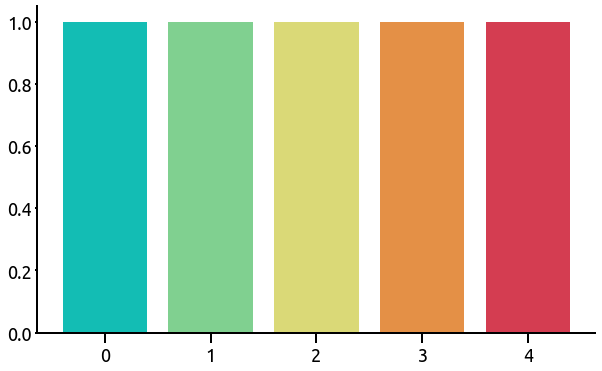

In [37]:
fig, axes = plt.subplots()
heights = np.ones(len(palette))
labels = [i for i in range(len(palette))]
c = [c for c in palette]
axes.bar(height=heights, x=labels, color=c)

In [38]:
writing_lengths = []
for body in df['writing_sample']:
    writing_lengths.append(len(body))
    
writing_lengths.sort()
print(f'Writing Length Range\nShortest description: {np.min(writing_lengths)} - Longest description: {np.max(writing_lengths)}')

Writing Length Range
Shortest description: 187 - Longest description: 15346


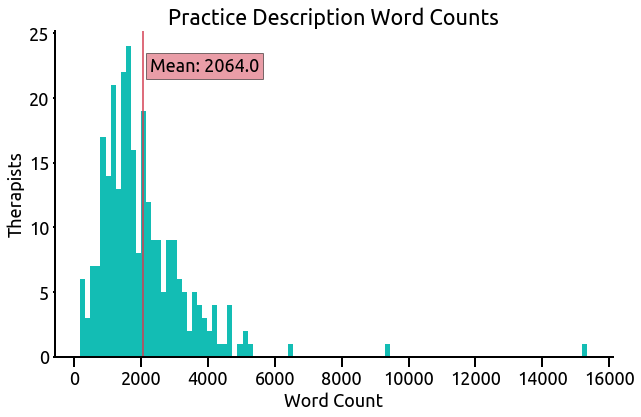

In [43]:
mean = np.mean(writing_lengths)
mean_label = f'Mean: {np.around(mean, decimals=0)}'
c1 = palette[0]
c2 = palette[4]
fig, ax = plt.subplots()
ax.set_xlabel('Word Count')
ax.set_ylabel('Therapists')
ax.set_title('Practice Description Word Counts')
ax.hist(writing_lengths, bins=100, color=c1)
ax.axvline(x=mean, c=c2)
plt.text(mean+200, 22, mean_label, bbox=dict(facecolor=c2, alpha=0.5))
plt.savefig('../img/data_vis/word_count_hist.png')
plt.show()

In [44]:
# number of unique values per category
age_groups_unique_size = df_age_groups['age_group'].unique().size
issues_unique_size = df_issues['issue'].unique().size
orientations_unique_size = df_orientations['orientation'].unique().size
professions_unique_size = df_professions['profession'].unique().size
service_unique_size = df_services['service'].unique().size

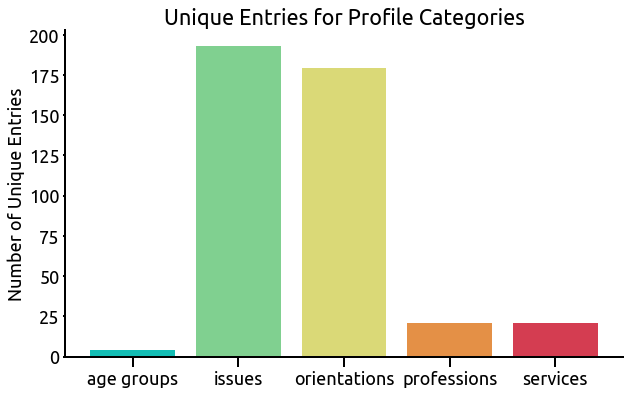

In [45]:
heights = [age_groups_unique_size, issues_unique_size, orientations_unique_size,
           professions_unique_size, service_unique_size]
labels = ['age groups', 'issues', 'orientations', 'professions', 'services']
colors = [palette[i] for i in range(len(heights))]

fig, ax = plt.subplots()
ax.set_title('Unique Entries for Profile Categories')
ax.set_ylabel('Number of Unique Entries')
ax.bar(height = heights, x=labels, color=colors)
plt.savefig('../img/data_vis/uniques_per_category.png')
plt.show()

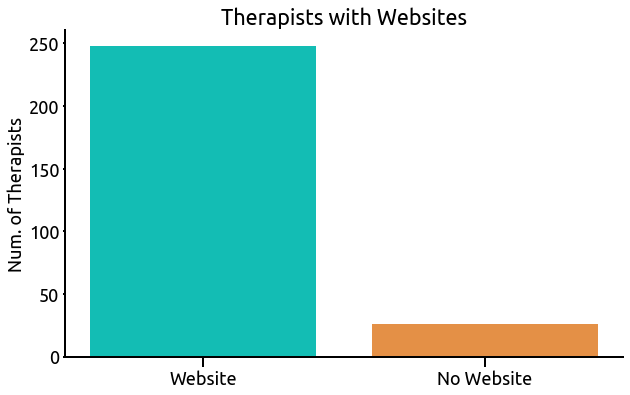

In [47]:
mask_no_website = df['website']=='None'
height = [df[~mask_no_website]['website'].size, df[mask_no_website]['website'].size]
labels = ['Website', 'No Website']

c = [palette[0], palette[3]]
fig, ax = plt.subplots()
ax.bar(labels, height, color=c)
ax.set_ylabel('Num. of Therapists')
ax.set_title("Therapists with Websites")
plt.savefig('../img/data_vis/website_bar.png')
plt.show()